# NUERAL NETWORK PROJECT-AMAZON STOCK MARKET PPREDICTION 

# TABLE OF CONTENTS 

1. Amazon Stock-Data Pipeline



2. Data Analysis 

      2.1 Data Exploration Analysis
      
      2.2 Data Exploration Analysis-Outlier Detection & Distribution
      
      
      
3. Feature Engineering

      3.1 Historical stock price movements  
      
      3.2 Amazon Stock Perfomance
      
      3.3 Stock Market indicators (RSI)
      
      3.4 Volume of trades
      
      3.5 Stock prices moving average
      
      3.6 Pairplot :Establish relationships,patterns and correlation
      
      
      
4. Data Pre-processing 

      4.1 Dropping outlier data/unrelated data(improve model perfomance)
      
      
      
      
      
5. Data Modelling 

      5.1 Preparation training set
      
      5.2 Preparation testing set 
      
      5.3 Compile model
      
      5.4 Model prediction 
      
      5.5 Model Optimization
      
      
      
6. Model Summary 

      6.1 Model outcome
      
      6.2 Project Summary/Conclusion


In [ ]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=82019ded73121a7057db2766a2618273a3f83fb1aae66720089eb945ec4351f3
  Stored in directory: /root/.cache/pip/wheels/6a/76/03/7f785aaa50b9c6ec7e3fd105a62c1b2c45a034512d51e024a9
Successfully built ta


In [ ]:
import yfinance as yahoo_finance
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 1.AMAZON STOCK DATA PIPELINE 

Amazon stock prices data would be fetched directly from the yahoo finance 

Data fetched would mantain a 10 year period,from 10 years ago until now.

All the variables(Open, High, Low, and Close prices) are auto_adjusted, By adjusting the historical prices for dividends and splits, it computes a scaling factor that is the ratio of the adjusted close price to the unadjusted close price. 

This adjustment is beneficial because dividends and stock splits can have a substantial impact on stock prices, and factoring them in can result in a more precise representation of the stock price movements over time.

In [ ]:
ticker = 'AMZN'
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=3652)).strftime('%Y-%m-%d')

def fetch_AMZN_data():
    AMZN_stock_data = yahoo_finance.download(ticker, start_date, end_date, interval='1d',
                                         auto_adjust=True)[['Open', 'High', 'Low', 'Close', 'Volume']]
    return pd.DataFrame(AMZN_stock_data)

AMZN_data = fetch_AMZN_data()


[*********************100%***********************]  1 of 1 completed


In [ ]:
AMZN_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2013-04-12,13.5060,13.6635,13.3510,13.6435,57326000
2013-04-15,13.5540,13.7560,13.3550,13.3860,66520000
2013-04-16,13.4655,13.6400,13.4030,13.6170,42744000
2013-04-17,13.5400,13.5425,13.2125,13.3700,62702000
2013-04-18,13.3405,13.3495,12.8300,12.9710,62752000


# 2.DATA ANALYSIS 


# 2.1 Data Exploration Analysis

The Open, High, Low, and Close columns have 2518 non-null values,indicating that they are no missing fields or values in our dataset

The mean Open value is 75.94, High value is 76.81, Low value is 74.96, and Close value is 75.90.These are the average stock prices which have a slight difference from each values 

The standard deviation of Open is 52.55, High is 53.20, Low is 51.83, and Close is 52.50.The standard deviation values for Open, High, Low, and Close are all fairly close to each other, indicating that the stock prices did not vary significantly from day to day over the given time period.


The percentiles provides a useful summary of the distribution of stock prices over time and would be utilised to understand the range and variability of the data.

The 25th percentile of Open is 26.74, High is 26.99, Low is 26.36, and Close is 26.72.

The 50th percentile of Open is 75.11, High is 76.39, Low is 73.99, and Close is 75.01.

The 75th percentile of Open is 108.07, High is 110.62, Low is 106.31, and Close is 107.95.

25th percentile of Open, High, Low, and Close is around 26-27 indicates that a significant portion of the stock prices during this time period were relatively low. 

The 50th percentile values, which are higher, suggest that half of the observations were higher than this value, while half were lower. 

The 75th percentile values, which are even higher, indicate that there were some days where the stock prices were much higher than the average.


In [ ]:
AMZN_data.describe()

,Open,High,Low,Close,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,76.102282,76.980570,75.125496,76.068400,8.022709e+07
std,52.498177,53.147354,51.774465,52.446473,4.206482e+07
min,12.447000,12.646500,12.287500,12.411500,1.762600e+07
25%,26.872499,27.100000,26.458000,26.803499,5.374200e+07
50%,75.849998,76.809998,74.349998,75.598999,6.878600e+07
75%,108.103500,110.780502,106.320000,108.000000,9.292600e+07
max,187.199997,188.654007,184.839493,186.570496,4.771220e+08


In [ ]:
AMZN_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-04-12 to 2023-04-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2517 non-null   float64
 1   High    2517 non-null   float64
 2   Low     2517 non-null   float64
 3   Close   2517 non-null   float64
 4   Volume  2517 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.0 KB


In [ ]:
AMZN_data.shape

(2517, 5)

# 2.2 Data Exploration Analysis-Outlier Detection & Distribution

Volume has positively skewed distribution with a tail that extends towards the positive (higher) values on the x-axis. This is  an indication that they are few extreme values that are much higher than the rest of the data. The mean of a positively skewed distribution is higher than the median, since the mean is more sensitive to outliers than the median and indicates the presence of high values that are further from the median.

Volume consists of values that are outliers as indicated on the box plot they stretch beyond or outside the intequartile range ,to improve the perfomance of the model the outliers would be eliminated or dropped.Figures to be dropped would be between 151964000 & 477122000

8.2 % of dataset represents outlier data or figures.The outliers would be dropped though this is significant low figure it would not have a huge impact on our results or outcomes 

Open,High,Close and Low does not have any outliers 


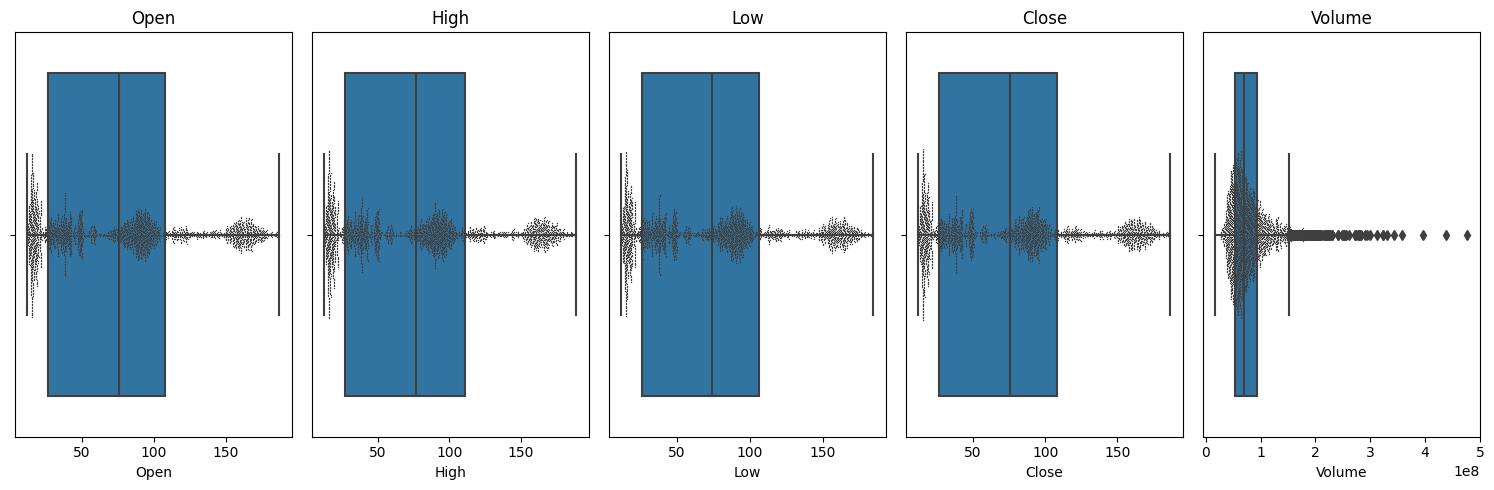

In [ ]:
features = ["Open", "High", "Low", "Close", "Volume"]
AMZN_stock= pd.DataFrame()
for feature in features:
    AMZN_stock[feature] = AMZN_data[feature]

fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5))
for i, feature in enumerate(features):
    sns.boxplot(x=AMZN_stock[feature], ax=axes[i])
    sns.swarmplot(x=AMZN_stock[feature], color=".25",s=1, ax=axes[i])
    axes[i].set_title(feature)
    
plt.tight_layout()
plt.show()


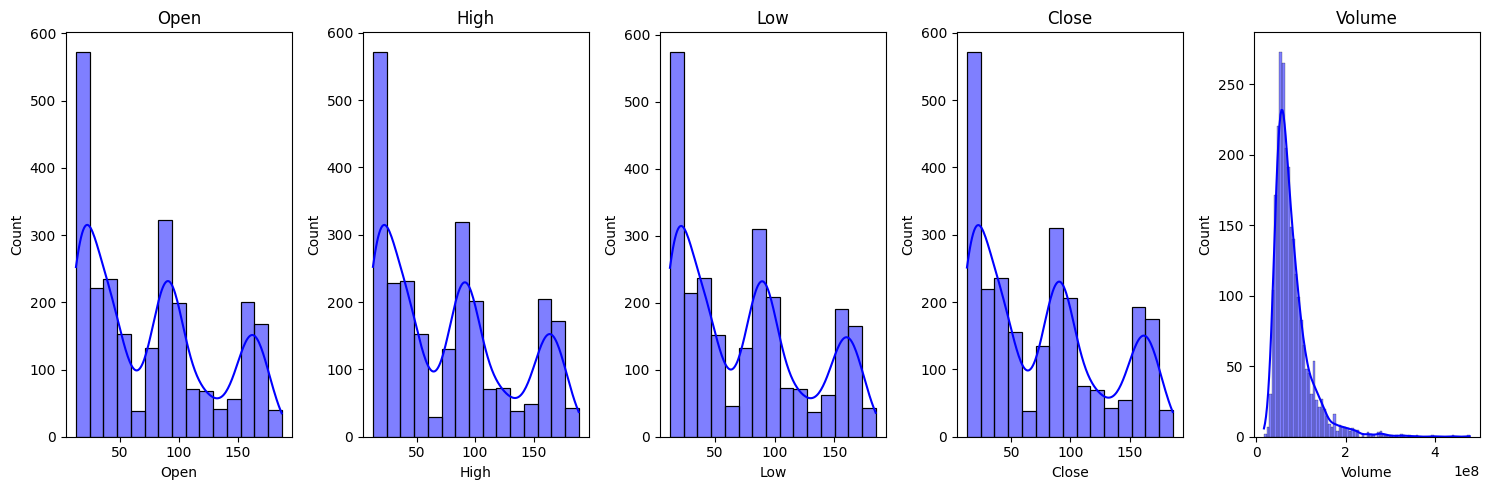

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15,5))
for i, feature in enumerate(features):
    sns.histplot(x=AMZN_stock[feature], ax=axes[i], kde=True,color="blue")
    axes[i].set_title(feature)
    
plt.tight_layout()
plt.show()

In [ ]:
Q1 = AMZN_data['Volume'].quantile(0.25)
Q3 = AMZN_data['Volume'].quantile(0.75)
IQR = Q3 - Q1
outliers = (AMZN_data['Volume'] < Q1 - 1.5*IQR) | (AMZN_data['Volume'] > Q3 + 1.5*IQR)
volume_outliers = AMZN_data.loc[outliers, 'Volume']
print(volume_outliers.min())
print(volume_outliers.max())

151964000
477122000


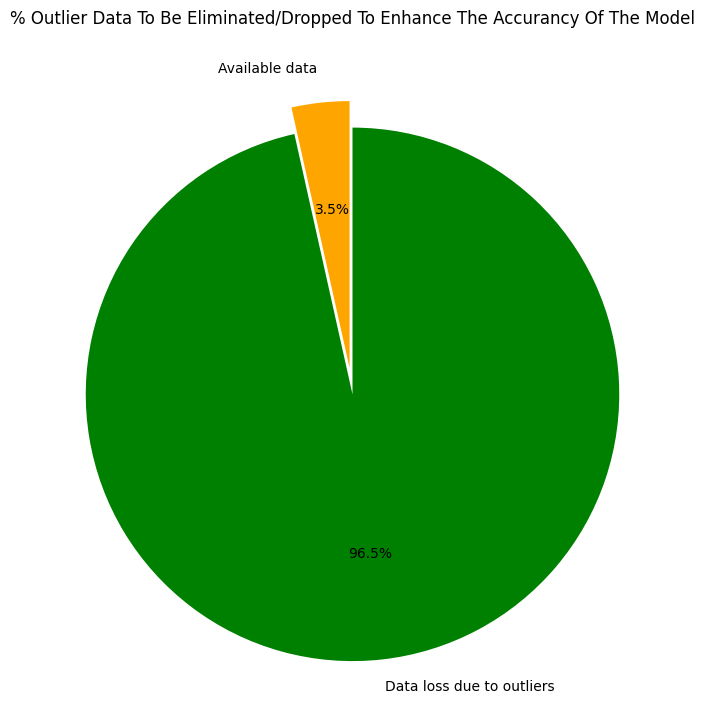

In [ ]:
# Calculate the outlier percentage
Q1 = AMZN_data.quantile(0.25)
Q3 = AMZN_data.quantile(0.75)
IQR = Q3 - Q1
AMZN_data = AMZN_data.apply(pd.to_numeric, errors='coerce')
outlier_perc = 100 * ((AMZN_data < (Q1 - 1.5 * IQR)) | (AMZN_data > (Q3 + 1.5 * IQR))).sum(axis=1) / len(AMZN_data.columns)
total_outlier_perc = outlier_perc.sum()

# Create the labels for the plot
labels = ['Available data\n', 'Data loss due to outliers']
values = [100, total_outlier_perc]
colors = ['orange', 'green']
explode = (0, 0.1,)
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('% Outlier Data To Be Eliminated/Dropped To Enhance The Accurancy Of The Model\n\n')
plt.show()

# 3.FEATURE ENGINEERING

# 3.1 Historical stock price movements 

Over the years Amazon Stock prices has been rising significantly from as low as $13 to $178 

They has been a steadily increase since 2013 until mid 2018 where they was a sudden drop in stock prices.

Year 2021 experienced high stock prices of about $178 with year 2013 achieving the lowest 

Amazon's stock is have been relatively volatile, meaning that its price has been fluctuating significantly over short periods of time from 2019 to 2023

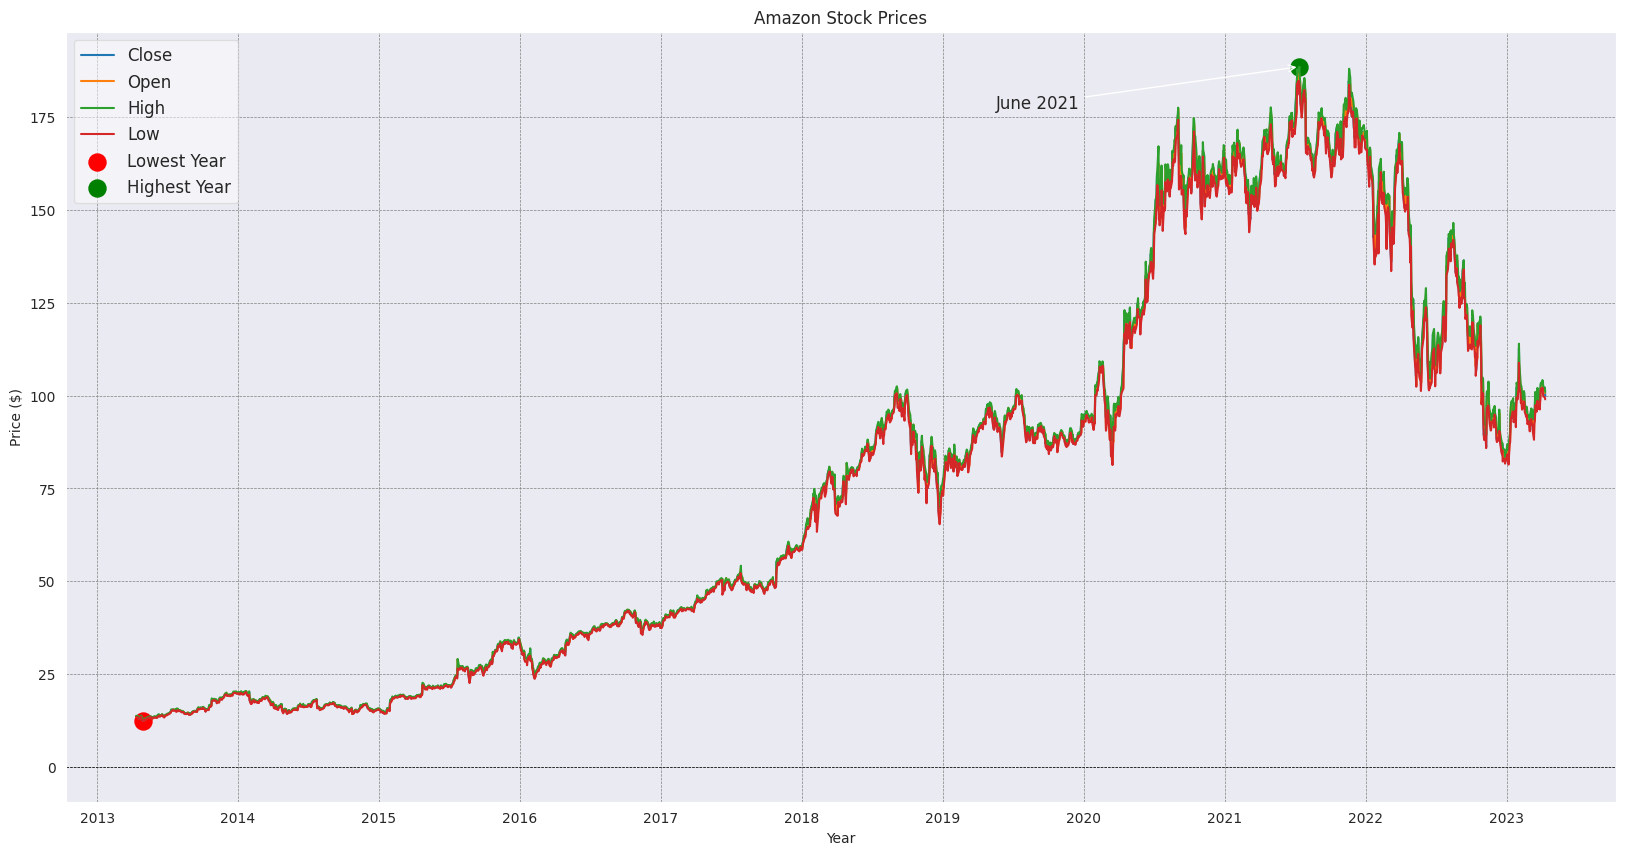

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(AMZN_data['Close'], label='Close')
ax.plot(AMZN_data['Open'], label='Open')
ax.plot(AMZN_data['High'], label='High')
ax.plot(AMZN_data['Low'], label='Low')
low_year = AMZN_data['Low'].idxmin()
high_year = AMZN_data['High'].idxmax()
ax.scatter(low_year, AMZN_data.loc[low_year, 'Low'], s=150, color='red', label='Lowest Year')
ax.scatter(high_year, AMZN_data.loc[high_year, 'High'], s=150, color='green', label='Highest Year')
ax.set_xlabel('Year')
ax.set_ylabel('Price ($)')
ax.set_title('Amazon Stock Prices')
ax.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.5, fontsize='large')
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.annotate("June 2021",xy=(AMZN_data['High'].idxmax(), AMZN_data['High'].max()), xytext=(0.6, 0.9),
            textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3'),
            fontsize='large')
plt.show()



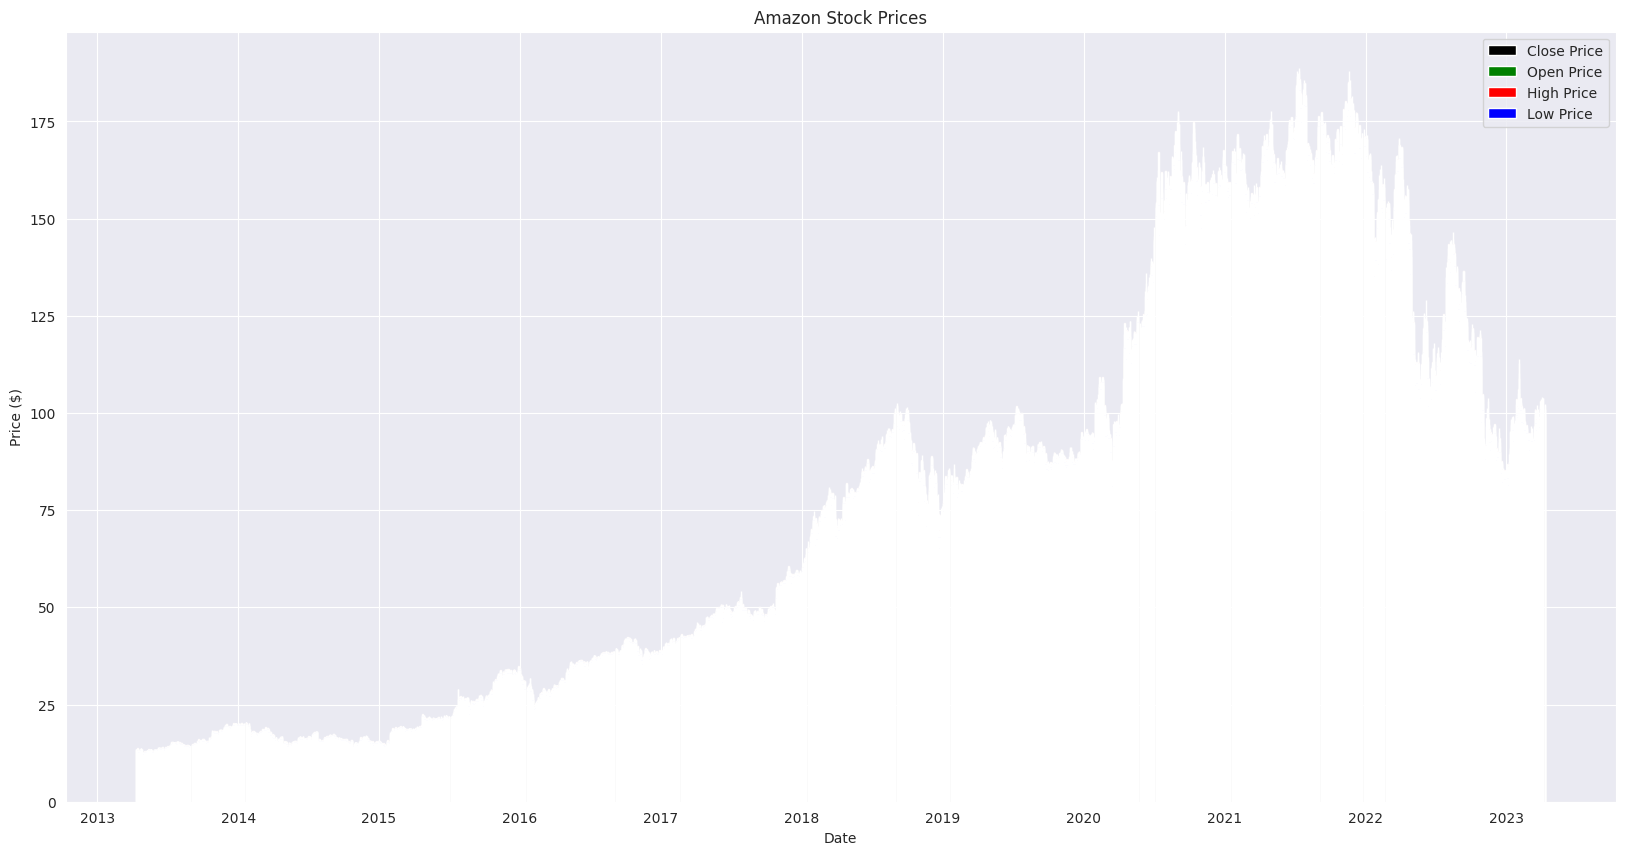

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(AMZN_data.index, AMZN_data['Close'], label='Close Price', color='black')
ax.bar(AMZN_data.index, AMZN_data['Open'], label='Open Price', color='green')
ax.bar(AMZN_data.index, AMZN_data['High'], label='High Price', color='red')
ax.bar(AMZN_data.index, AMZN_data['Low'], label='Low Price', color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('Amazon Stock Prices')
ax.legend(loc='best')

plt.show()

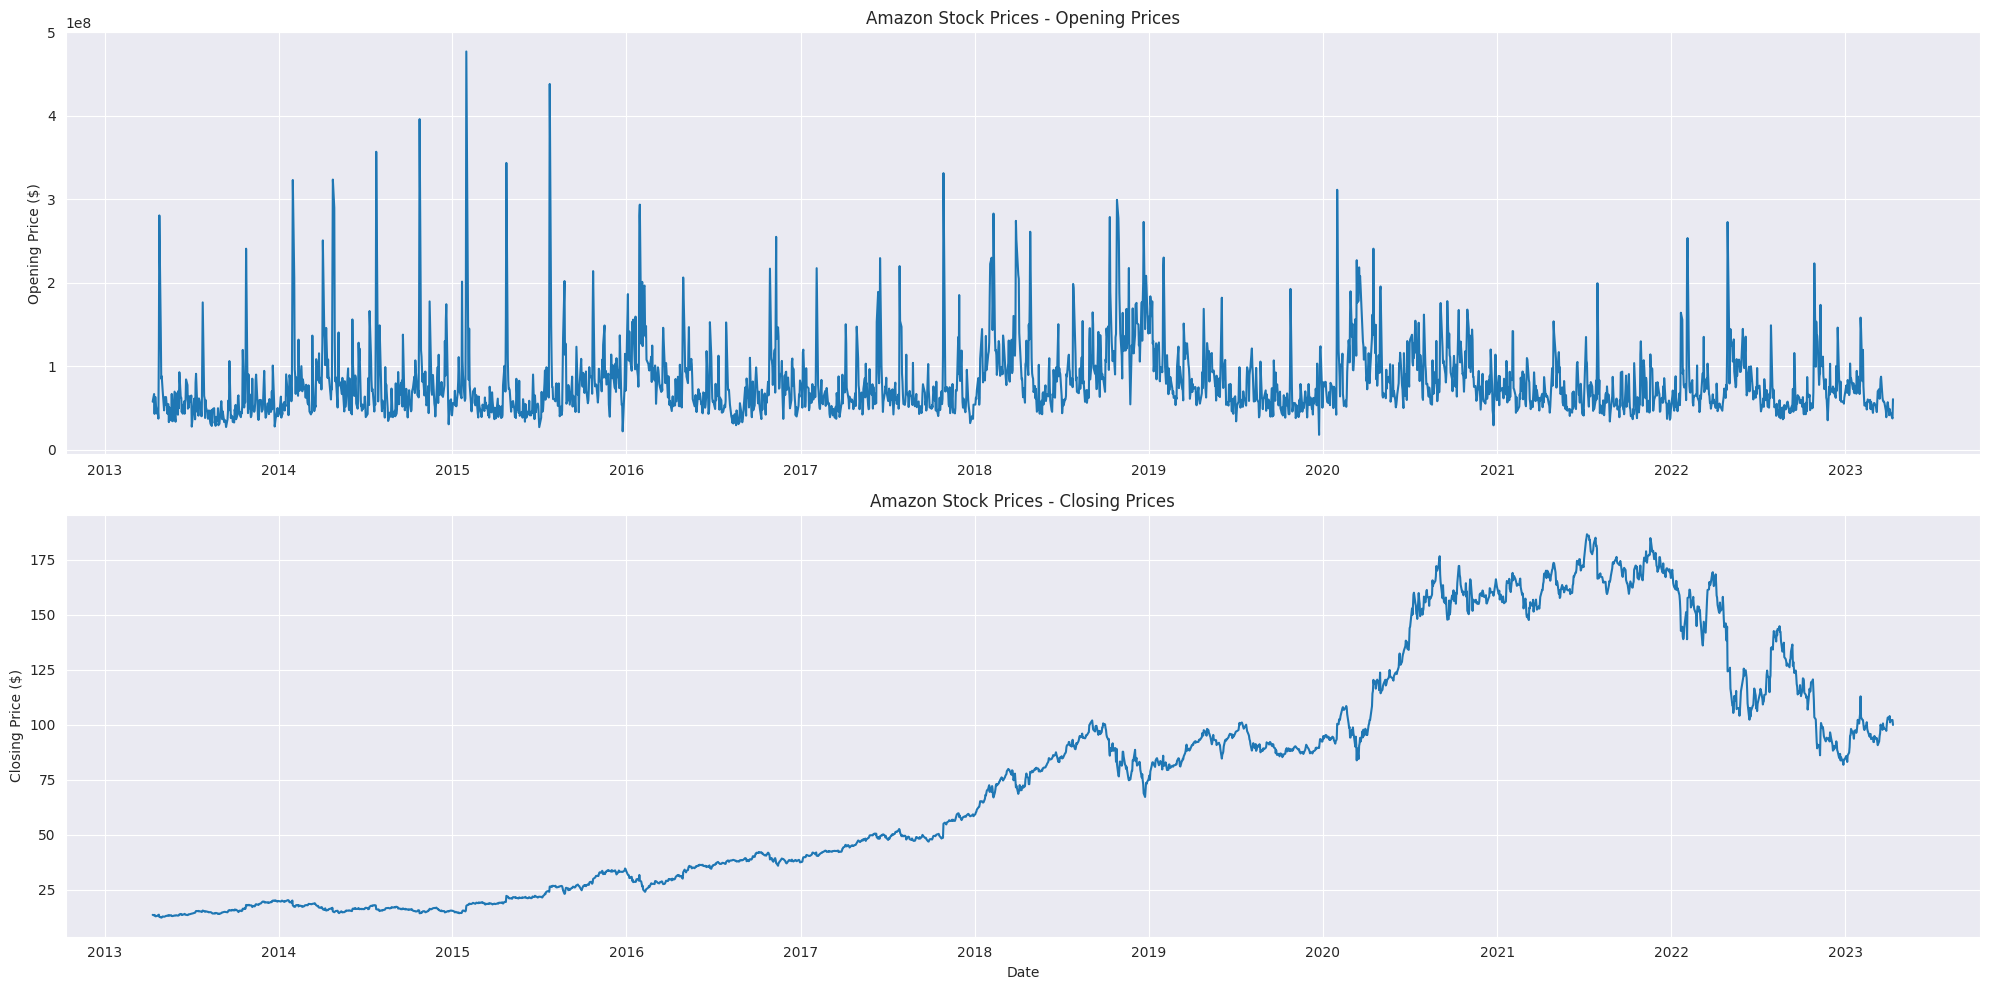

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
# plot opening prices on top subplot
axs[0].plot(AMZN_data['Open'].index, AMZN_data['Volume'])
axs[0].set_ylabel('Opening Price ($)')
axs[0].set_title('Amazon Stock Prices - Opening Prices')

# plot closing prices on bottom subplot
axs[1].plot(AMZN_data['Close'].index, AMZN_data['Close'])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Closing Price ($)')
axs[1].set_title('Amazon Stock Prices - Closing Prices')

plt.tight_layout()
plt.show()

# 3.2 Amazon Stock Perfomance 

Amazon daily returns exceeded the daily returns of the Nasdaq indicating great stock market perfomance 

The daily returns of Amazon have consistently exceeded the daily returns of the Nasdaq Composite index over a given time period. This indicates that Amazon has been outperforming the broader market represented by the Nasdaq Composite index.

Daily returns represent the percentage change in the stock price from one day to the next. When Amazon's daily returns exceed the daily returns of the Nasdaq Composite index, it suggests that Amazon is generating higher returns for its investors compared to the broader market. This could be due to several factors such as strong financial performance, positive news and announcements, or market dominance in its industry.

Amazon daily returns exceeded the daily returns of the S&P indicating great stock market performance

[*********************100%***********************]  1 of 1 completed


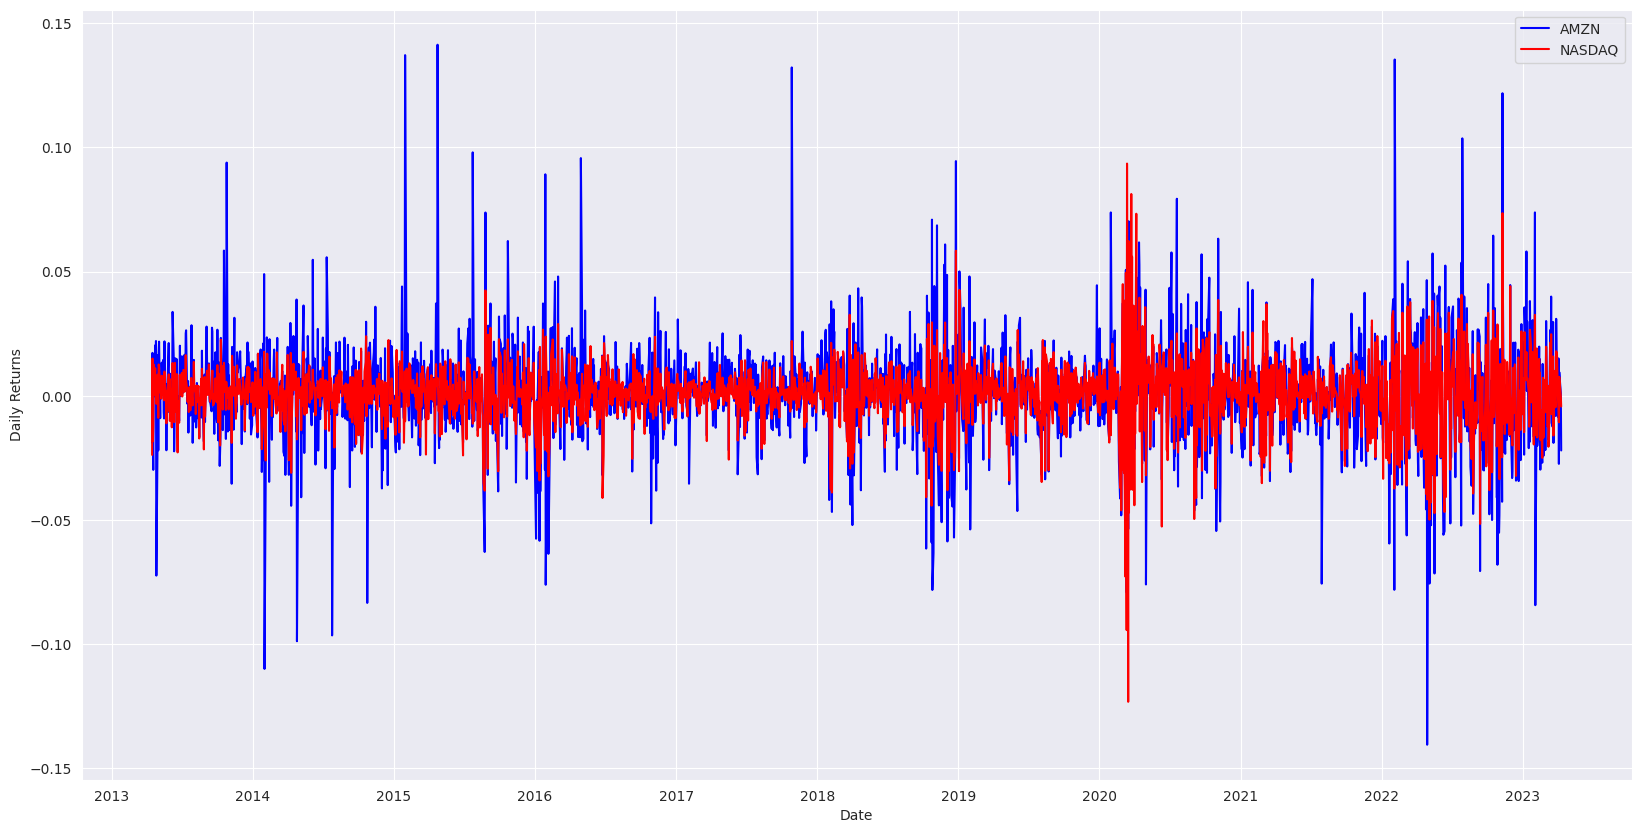

In [ ]:
# Plot the daily returns of Amazon and NASDAQ
# Market perfomance relative to S&P bench mark 
nasdaq_data = yahoo_finance.download("^IXIC",start=start_date, end=end_date)


Daily_returns_AMZN = AMZN_data['Close'].pct_change()
Daily_returns_nasdaq_data = nasdaq_data['Close'].pct_change()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Daily_returns_AMZN.index, Daily_returns_AMZN, label='AMZN',color="blue")
ax.plot(Daily_returns_nasdaq_data.index, Daily_returns_nasdaq_data, label='NASDAQ',color="red")
ax.set_xlabel('Date')
ax.set_ylabel('Daily Returns')
ax.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


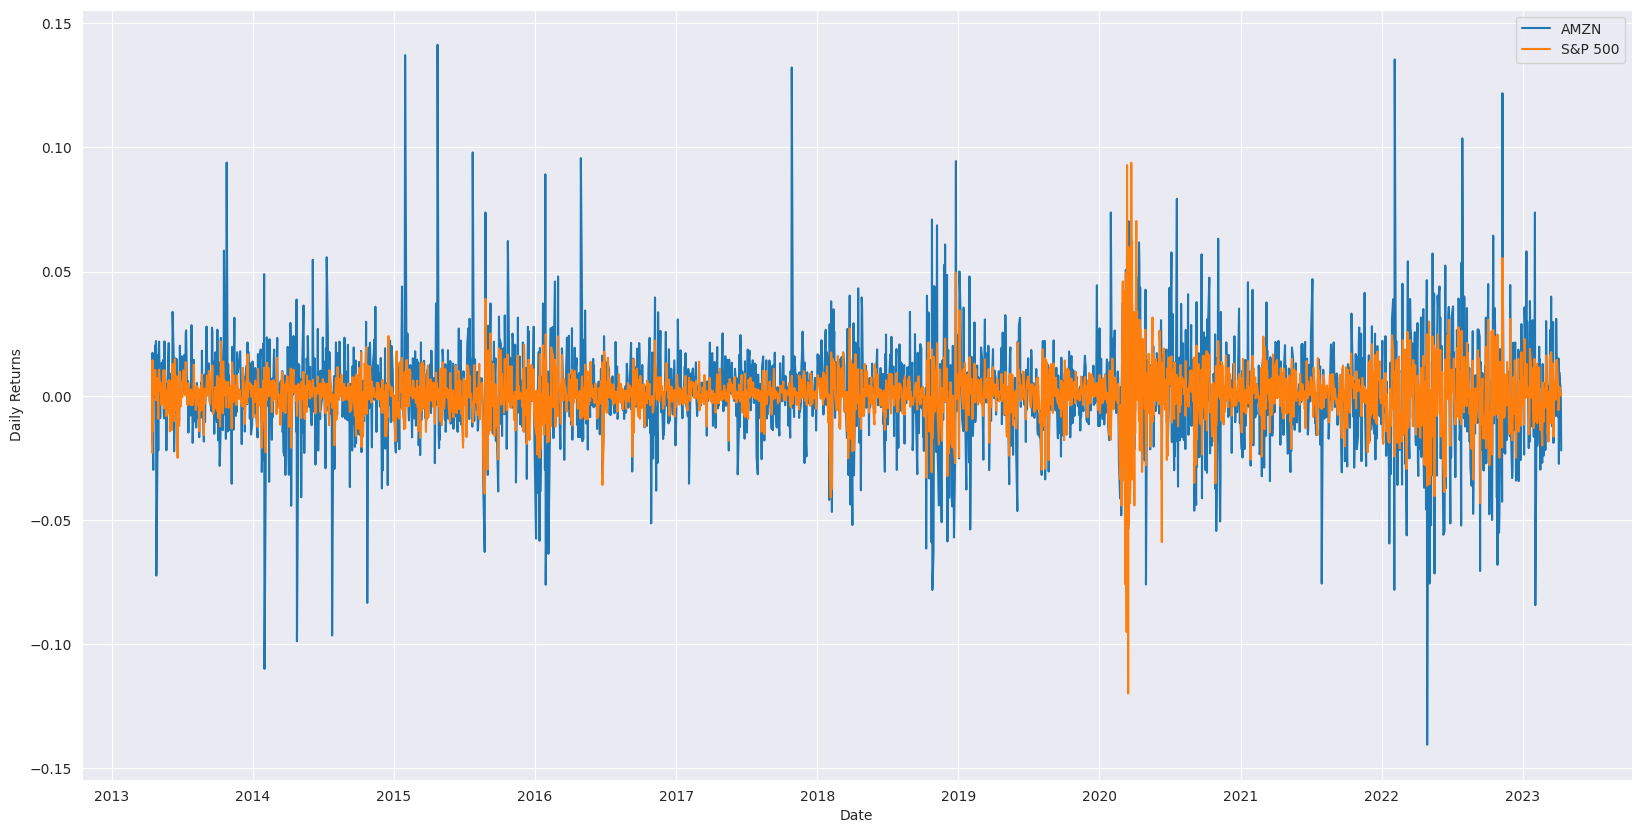

In [ ]:
#Market perfomance relative to S&P bench mark 

S_and_P = yahoo_finance.download("^GSPC", start=start_date, end=end_date)

# Calculate daily returns
Daily_returns_AMZN = AMZN_data['Close'].pct_change()
Daily_returns_SP = S_and_P['Close'].pct_change()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Daily_returns_AMZN .index,Daily_returns_AMZN, label='AMZN')
ax.plot(Daily_returns_SP.index,Daily_returns_SP, label='S&P 500')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Returns')
ax.legend()
plt.show()

# 3.3 Stock Market indicators (RSI)

The Relative Strength Index (RSI) is a technical indicator used in financial analysis to measure the strength of a security's price action. It is calculated using the average gains and losses of a security over a specified time period (typically 14 days) and is displayed on a scale of 0 to 100.

The RSI is considered a momentum oscillator that measures the magnitude and velocity of directional price movements. It is particularly useful for identifying overbought and oversold conditions in a security's price.

If the RSI is above 70, it suggests that the security is overbought, meaning that its price may be due for a correction. Conversely, if the RSI is below 30, it indicates that the security is oversold, meaning that its price may be due for a rebound.

Amazon experienced quite a few scenarios where the closing price was above the RSI of 70 and below RSI of low 30,this is a vital tool to analyse exit and buying points 

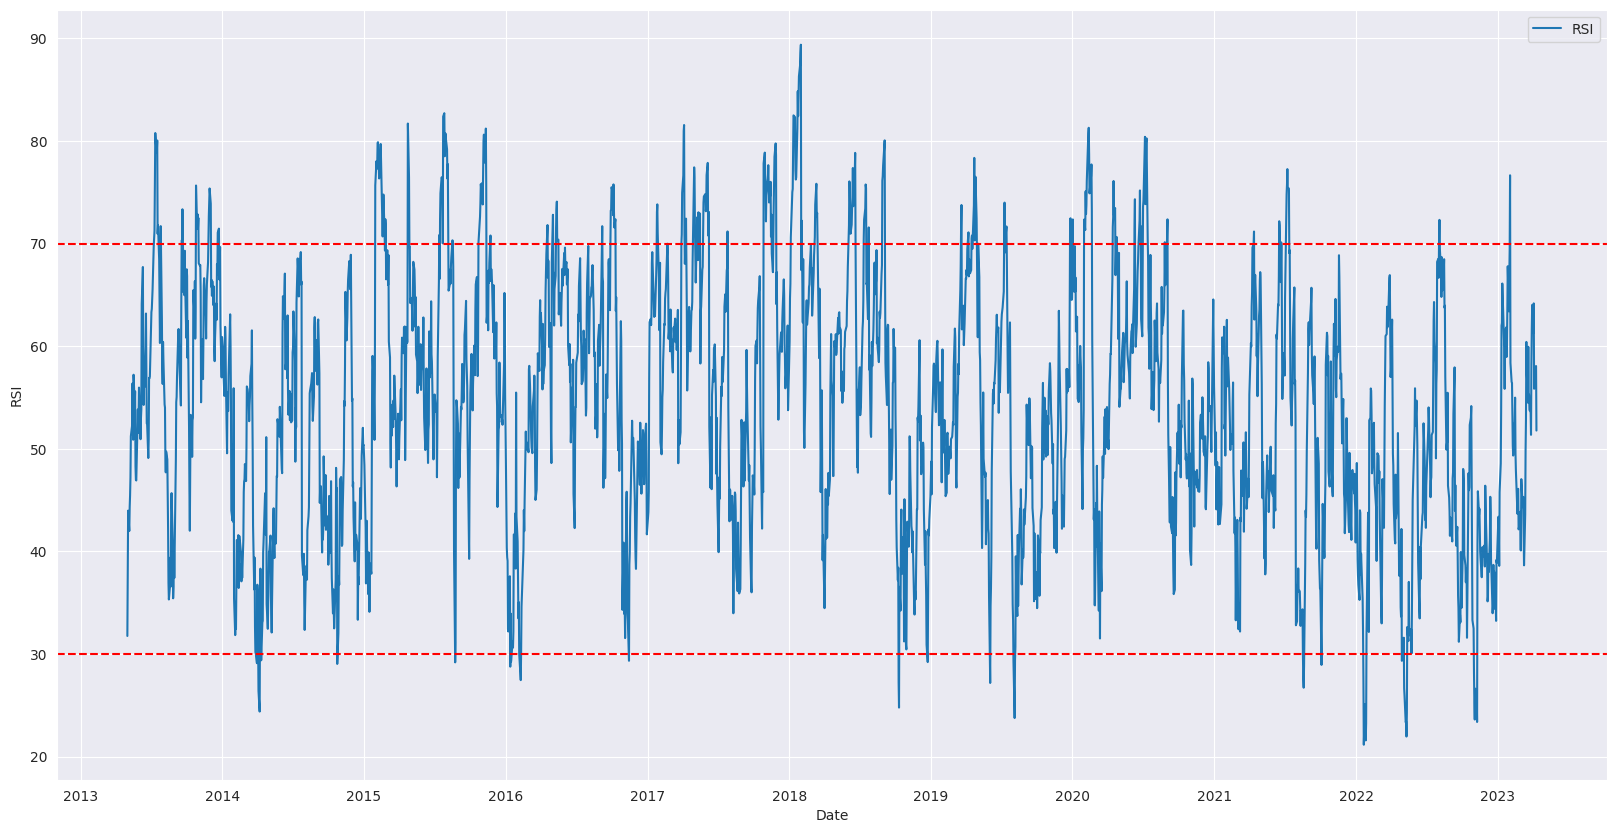

In [ ]:
# Calculate the relative strength index (RSI) using the ta library

rsi_indicator = RSIIndicator(AMZN_data['Close'], window=14)
AMZN_data['RSI'] = rsi_indicator.rsi()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(AMZN_data.index, AMZN_data['RSI'], label='RSI')
ax.axhline(y=30, color='red', linestyle='--')
ax.axhline(y=70, color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('RSI')
ax.legend()
plt.show()

# 3.4 Volume of trades 

This analysis establishes the volumes of trade with the highest and lowest points.

Volume of trades is a measure of market activity and will assist in determining the liquidity and price movements of a stock price

Amazon achieved most volume of trade in 2015 and least volume on trade in 2020

High trading volumes usually accompany significant price movements, which suggests strong market interest and participation.

Whilst low trading volumes may indicates a lack of investor interest or uncertainty in the market.

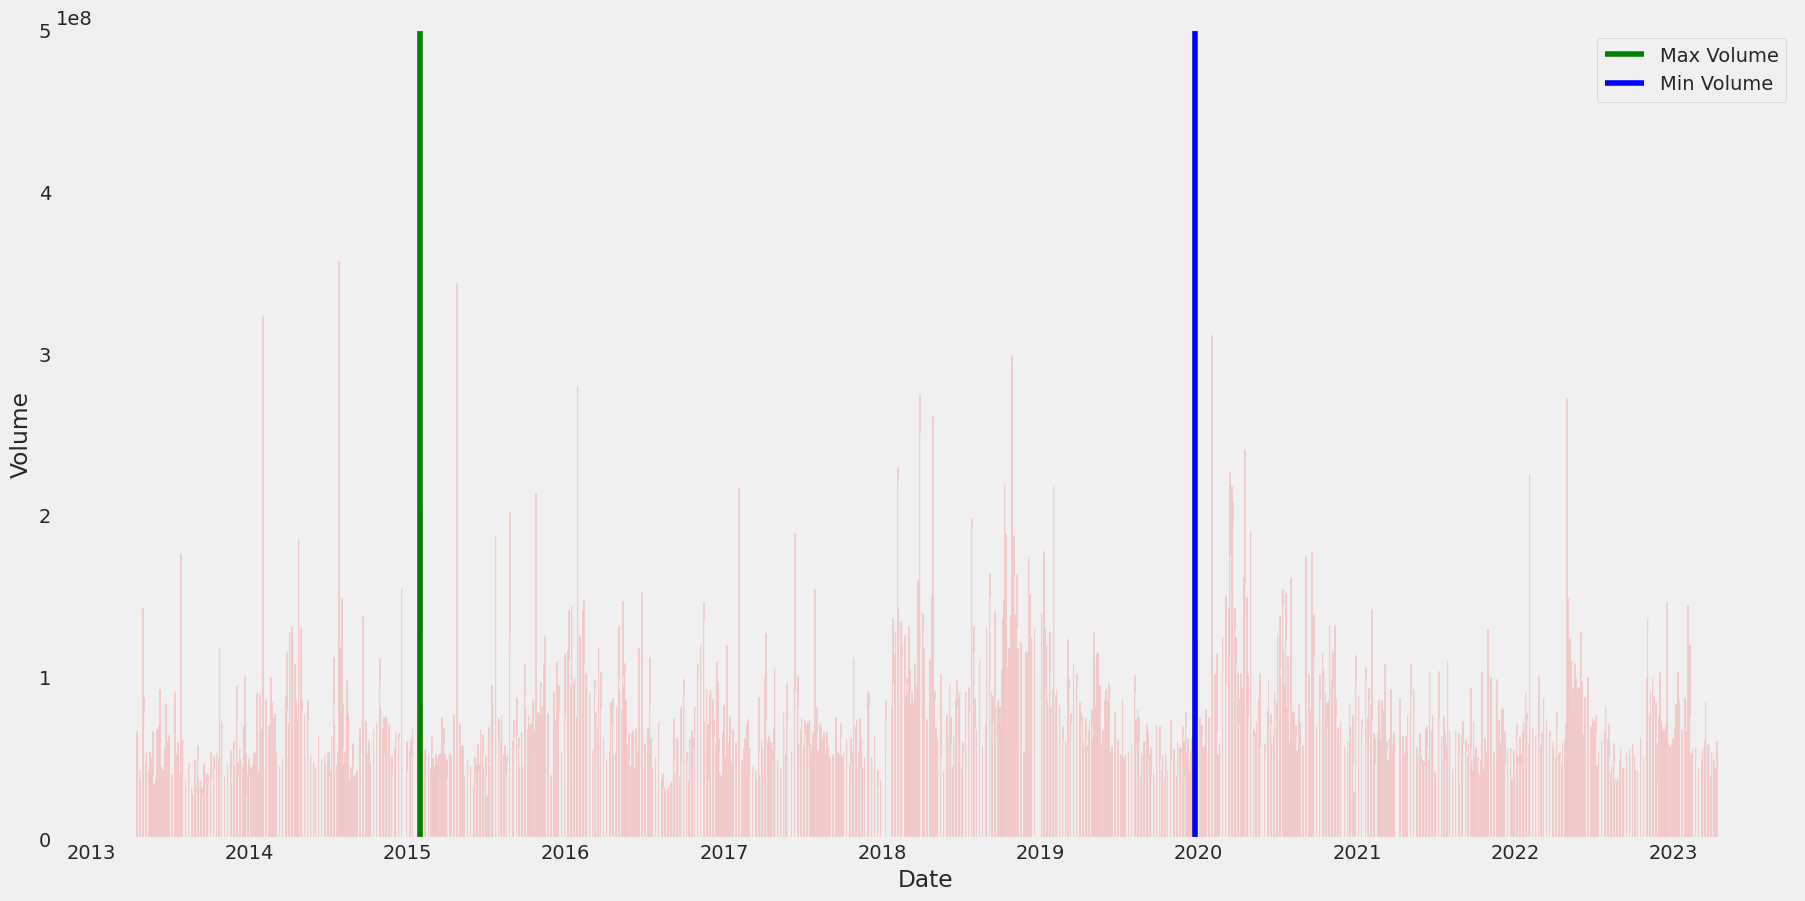

In [ ]:
max_volume_date = AMZN_data.loc[AMZN_data['Volume'].idxmax()].name
min_volume_date = AMZN_data.loc[AMZN_data['Volume'].idxmin()].name

# Plot the volume of trades using a bar chart
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(AMZN_data.index, AMZN_data['Volume'], color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.axvline(x=max_volume_date, color='green', label='Max Volume')
ax.axvline(x=min_volume_date, color='blue', label='Min Volume')
ax.legend()
ax.grid(False)
plt.show()

# 3.5 Stock prices moving average 

The purpose of analyzing moving averages is to identify trends and patterns in a dataset. Moving averages smooth out the fluctuations in the data and highlight the underlying trends. 

By calculating the moving average of a stock price over a certain time period, we can get a clearer picture of whether the stock is trending upward or downward

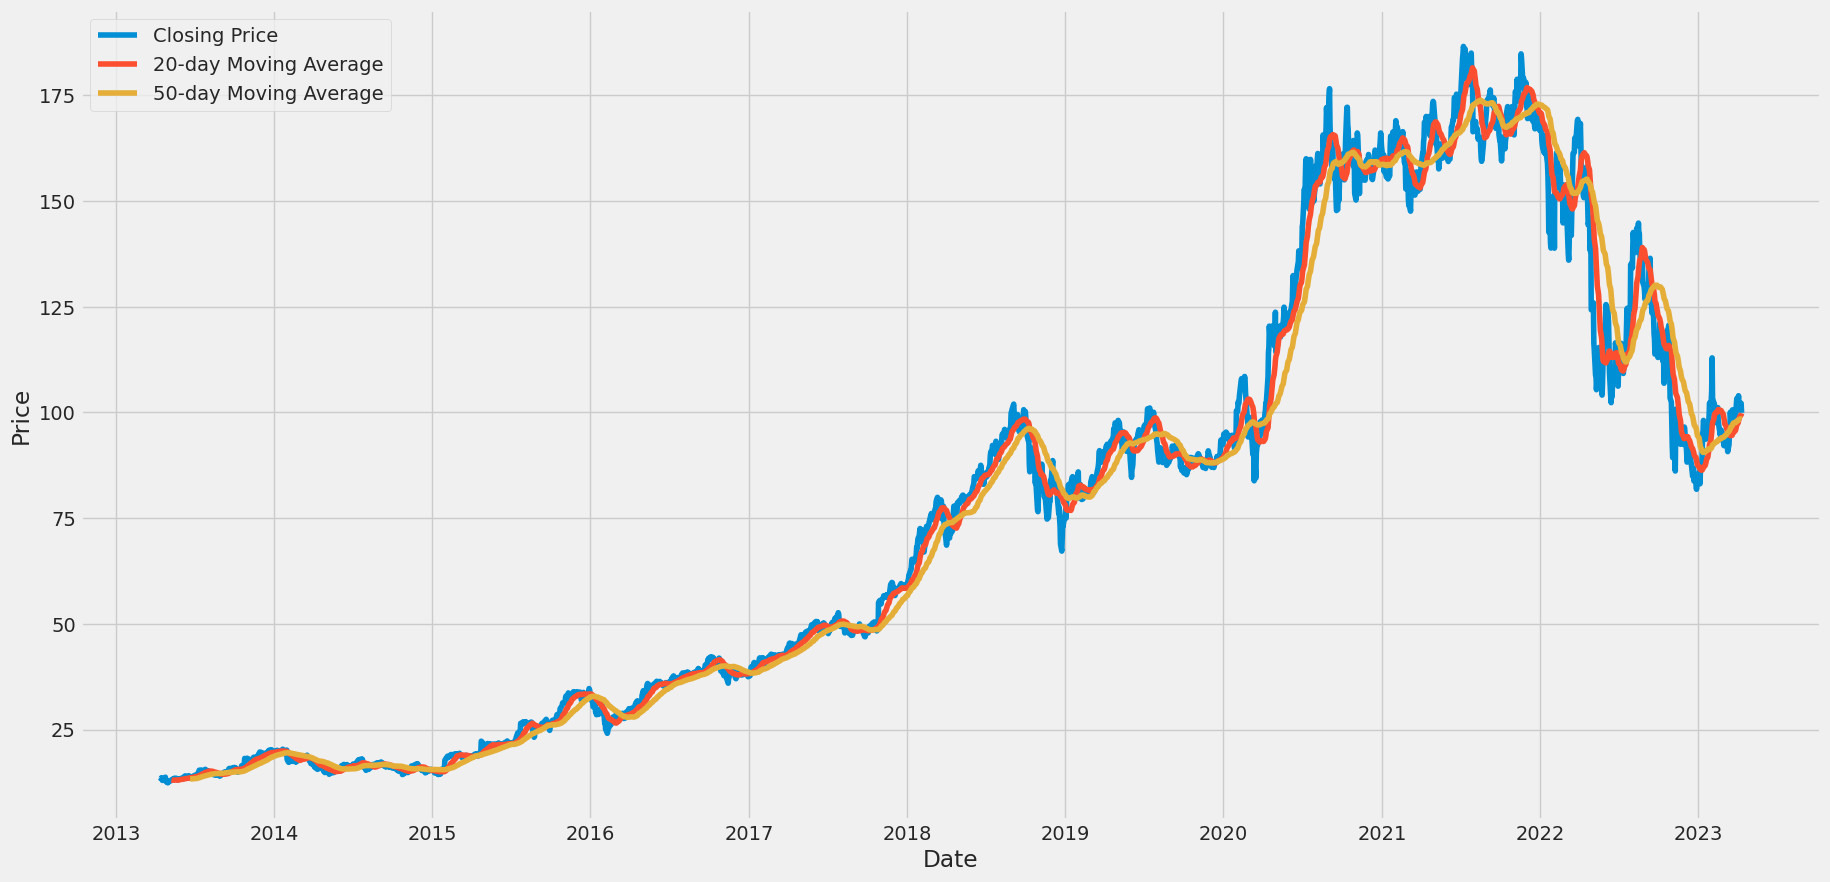

In [ ]:
# Plot the closing prices and moving averages
moving_avg_20 = AMZN_data['Close'].rolling(window=20).mean()
moving_avg_50 = AMZN_data['Close'].rolling(window=50).mean()


fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(AMZN_data.index, AMZN_data['Close'], label='Closing Price')
ax.plot(moving_avg_20.index,moving_avg_20, label='20-day Moving Average')
ax.plot(moving_avg_50.index,moving_avg_50, label='50-day Moving Average')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

plt.show()

# 3.6 Pairplot :Establish relationships,patterns and correlation

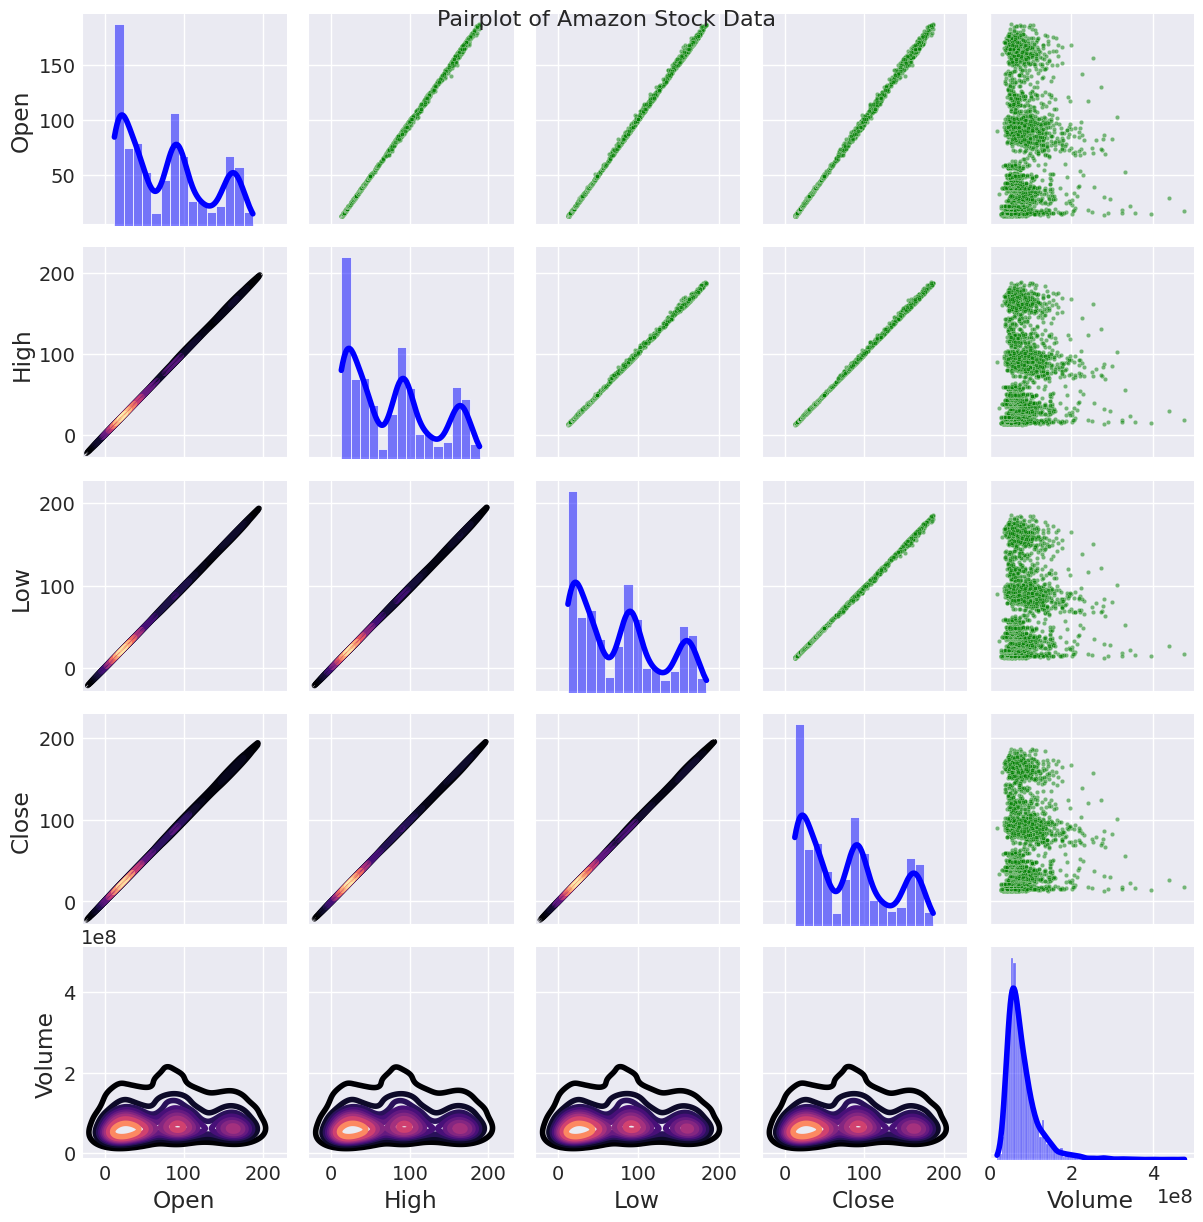

In [ ]:
features_AMZN = AMZN_data[["Open", "High", "Low", "Close", "Volume"]]
sns.set_palette("Set2")
sns.set_style("darkgrid")
g = sns.PairGrid(features_AMZN, diag_sharey=False)
g.map_upper(sns.scatterplot, s=10, alpha=0.5,color="green")
g.map_diag(sns.histplot, kde=True,color ='blue' )
g.map_lower(sns.kdeplot, cmap="magma", thresh=0.05)
plt.suptitle("Pairplot of Amazon Stock Data\n\n\n", fontsize=16)
legend_labels = ["Open", "High", "Low", "Close", "Volume"]
handles = [plt.plot([],[], marker="o", ls="", color=sns.color_palette()[i])[0] for i in range(len(legend_labels))]

g.fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# 4. DATA PRE-PROCESSING 

# 4.1 Dropping outlier data/unrelated data(improve model perfomance)

In [ ]:
AMZN_data['Volume'].shape


(2517,)

In [ ]:
print(volume_outliers.min())
print(volume_outliers.max())

151964000
477122000


In [ ]:
AMZN_data[AMZN_data['Volume'] >151964000]

,Open,High,Low,Close,Volume,RSI
Date,,,,,,
2013-04-26,13.498500,13.601000,12.640500,12.740500,280600000,NaN
2013-07-26,14.977500,15.681000,14.777500,15.600500,176350000,71.705386
2013-10-25,17.930000,18.420000,17.631001,18.169500,240736000,75.663839
2014-01-30,19.688499,20.312500,19.385000,20.150499,209478000,55.908881
2014-01-31,18.587999,18.772499,17.888000,17.934500,323096000,35.410122
...,...,...,...,...,...,...
2022-04-29,129.848999,130.761002,121.625000,124.281502,272662000,29.345901
2022-10-28,97.910004,103.959999,97.660004,103.410004,223133400,33.309477
2022-11-01,103.989998,104.580002,96.059998,96.790001,153370000,28.207111


In [ ]:
AMZN_data= AMZN_data.drop(AMZN_data[AMZN_data['Volume'] >151964000].index, axis = 0)

In [ ]:
AMZN_data.shape

(2380, 6)

In [ ]:
AMZN_data=AMZN_data.drop('RSI',axis=1)

# 5. DATA MODELLING

# 5.1 Preparation of training set 

To start, we extracted the closing prices from the acquired stock data and transform them into a numerical series.

Determined the size of the dataset that represents 80% of the data. To ensure an integer is used, the math.ceil method should be applied.

Next, used Scikit-Learn's MinMaxScaler to normalize the stock data to a range between 0 and 1. This normalized data should be reshaped into a two-dimensional array.

Separate the first 80% of the stock data as the training set.

Created two empty lists, one for the sequence of feature data (x_train) and the other for the sequence of label data (y_train).

Develop a window of historical prices that spans 60 days (i-60) to be used as our feature data (x_train), with the following 60-day window representing the label data (y_train).

Convert the feature data (x_train) and label data (y_train) into Numpy arrays, as this is the format required by TensorFlow for training a neural network model. Reshape the x_train and y_train data again into a three-dimensional array to satisfy the requirement for training an LSTM model.

In [ ]:
close_prices = AMZN_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 5.2 Preparation of testing set

Retrieved the closing prices from the normalized dataset, which represents the final 20% of the data and generated feature data (x_test) and label data (y_test) from our test set.

Transformed the feature data (x_test) and label data (y_test) into Numpy arrays. Then, reshape x_test and y_test into a three-dimensional array as required by the LSTM model.

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)

# 5.3 Compile a model

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=50, batch_size= 32, validation_split=0.2)

Epoch 1/50
47/47 [==============================] - 12s 35ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 2/50
47/47 [==============================] - 1s 12ms/step - loss: 9.1365e-04 - val_loss: 0.0038
Epoch 3/50
47/47 [==============================] - 1s 12ms/step - loss: 8.3252e-04 - val_loss: 0.0129
Epoch 4/50
47/47 [==============================] - 1s 11ms/step - loss: 7.8330e-04 - val_loss: 0.0087
Epoch 5/50
47/47 [==============================] - 1s 12ms/step - loss: 7.2856e-04 - val_loss: 0.0018
Epoch 6/50
47/47 [==============================] - 1s 12ms/step - loss: 6.8054e-04 - val_loss: 0.0086
Epoch 7/50
47/47 [==============================] - 1s 11ms/step - loss: 6.2000e-04 - val_loss: 0.0098
Epoch 8/50
47/47 [==============================] - 1s 11ms/step - loss: 6.5005e-04 - val_loss: 0.0070
Epoch 9/50
47/47 [==============================] - 1s 11ms/step - loss: 6.1918e-04 - val_loss: 0.0034
Epoch 10/50
47/47 [==============================] - 1s 12ms/step - loss: 6.

# 5.4 Model prediction

Employ the inverse_transform method to convert the predicted stock prices back to their original form.

Compute the RMSE to evaluate the difference between the predicted prices and the actual prices (y_test), and then display the result.

Based on the chart below, it is evident that the predicted stock prices generally align with the actual stock prices, albeit slightly lower. Initially, there was a significant gap between the two, but as the model was trained, the gap decreased. This indicates the LSTM's ability to effectively process sequential or time series data, such as stock prices.


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

15/15 [==============================] - 1s 6ms/step


7.663778817954183

<ipython-input-33-aa9d46566ea3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'Predictions'] = predictions


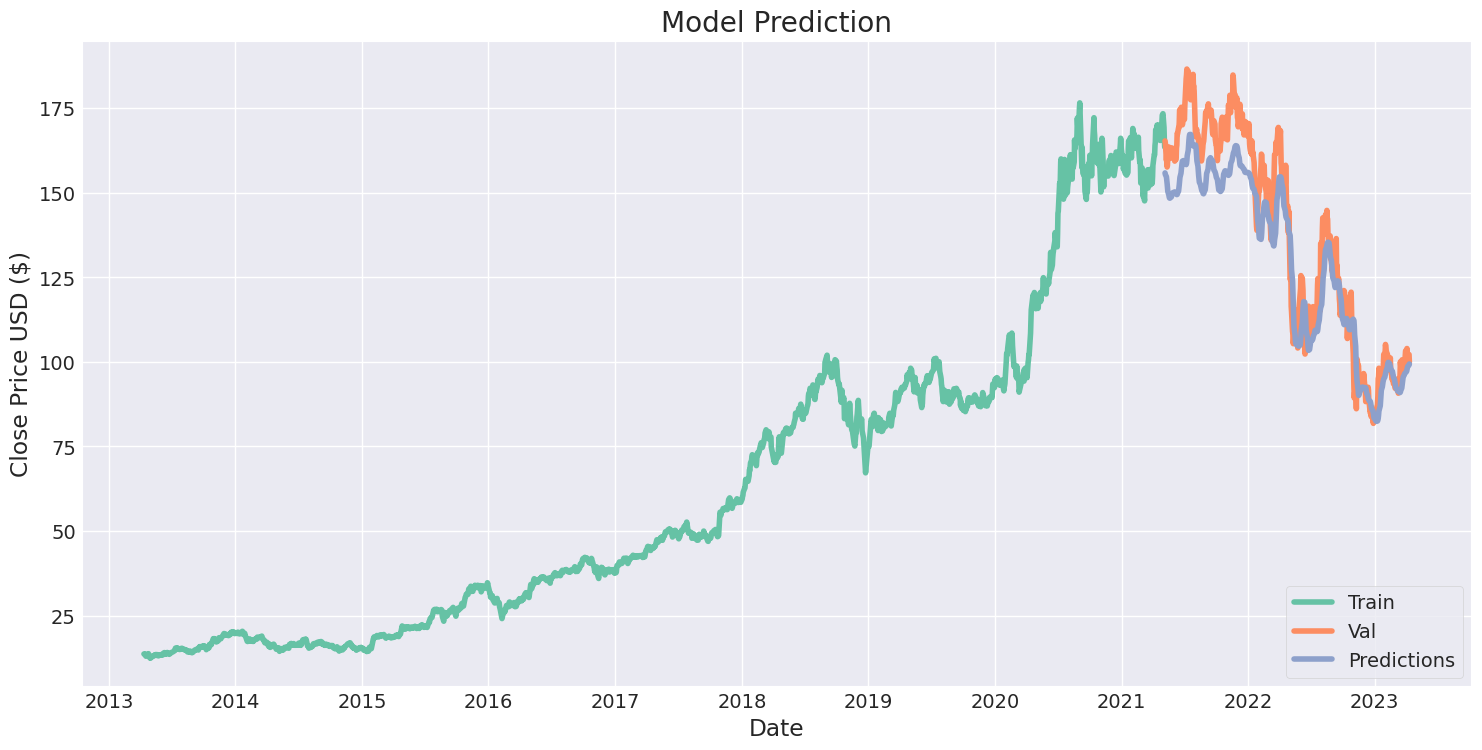

In [ ]:
data = AMZN_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation.loc[:, 'Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# 5.5 Model optimization 

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size= 32, validation_split=0.2)

Epoch 1/50
47/47 [==============================] - 7s 36ms/step - loss: 0.0401 - mean_absolute_error: 0.1592 - val_loss: 0.0078 - val_mean_absolute_error: 0.0759
Epoch 2/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0024 - mean_absolute_error: 0.0377 - val_loss: 0.0614 - val_mean_absolute_error: 0.2057
Epoch 3/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0011 - mean_absolute_error: 0.0257 - val_loss: 0.0539 - val_mean_absolute_error: 0.1928
Epoch 4/50
47/47 [==============================] - 1s 11ms/step - loss: 9.9135e-04 - mean_absolute_error: 0.0244 - val_loss: 0.0622 - val_mean_absolute_error: 0.2123
Epoch 5/50
47/47 [==============================] - 1s 11ms/step - loss: 7.9977e-04 - mean_absolute_error: 0.0215 - val_loss: 0.0487 - val_mean_absolute_error: 0.1828
Epoch 6/50
47/47 [==============================] - 1s 11ms/step - loss: 7.8748e-04 - mean_absolute_error: 0.0215 - val_loss: 0.0438 - val_mean_absolute_error: 0.1736
Epoch 7/50

# 6. MODEL SUMMARY 

# 6.1 Model outcome 

The model seems to be performing well at the beginning with a loss of 0.0052 in epoch 1, which drops to 0.0011 in epoch 2. However, the model's performance starts to fluctuate after that with an increase in loss in some epochs and a decrease in others. 

The model seems to be overfitting after epoch 25 as seen by the high validation loss of 0.080. The overfitting gets worse with the validation loss increasing in epoch 48 and in epoch 50.

Based on this observation, it may be necessary to stop training the model at epoch 17, as further training only leads to overfitting. 

In model optimization changing the activation to sigmoid slightly improved the model to a loss of 3.5e-04 from the previous model with a loss of 3.51e-04   The model seems to be performing well in terms of the training loss and mean absolute error (MAE), with both decreasing significantly after the first epoch. However, the validation loss and MAE start increasing after the third epoch. This suggests that the model is overfitting to the training data and is not able to generalize well to the validation data.

The overfitting problem becomes more severe after the ninth epoch, as seen by the significant increase in the validation loss and MAE. This suggests that the model is starting to memorize the training data and is not able to capture the underlying patterns in the data.

# 6.2 Project Summary/Conclusion

Though the model loss has been flactuating,the perfomance of the model increases at the end of the last epochs indicating the effectiveness the model.

Predicted values,initially they are further from the actual values but as it continue training the model the predicted values fall closer to the actual values

MAE is a common metric used to evaluate regression models, and it measures the average absolute difference between the actual and predicted values of the target variable. In this case, the model's MAE on the training set is 0.0144 indicating that the difference between the predicted and actual values is quite low resulting in an effective model perfomance.

val_loss of 0.0459 refers to the loss of the model on the validation set. Loss is a measure of how well the model is able to fit the data, with lower values indicating better performance. In this case, the model's loss on the validation set is 0.0459.

val_mean_absolute_error of 0.1760 refers to the MAE of the model on the validation set. This is similar to the training set MAE, but it measures the model's performance on a separate set of data that it hasn't seen during training. In this case, the model's MAE on the validation set is 0.1760. This is higher than the training set MAE, which suggests that the model may be overfitting to the training data and not generalizing well to new data.

In conclusion the model has some elements of over fitting in some epoch which could be eliminated either by running a certain number of epochs,reducing a number number of features or layers in a model,early stopping and use of cross validation